# Introduction to Neural Networks and Deep Learning

# Chapter 1d: Demonstration of the Style transfer method

## Prof. Aldo Humberto Romero, Physics Department, West Virginia University

## A lot of these notebooks are based on the course prepared at West Virginia University by the research computing group led by Aldo Humberto Romero by mostly done by Guillermo Avendaño-Franco.

This jupyter notebook focus on a cool example on how to use existing methods developed in NN. Here we will use the so called Style Transfer. The tutorial here is mostly based on the one found in

https://www.tensorflow.org/tutorials/generative/style_transfer

Style transfer is a computer vision technique that allows us to recompose the content of an image (a user provided image and also called content image) in the style of another (another image but one that we would like to use as the "style"). 

The original paper that describes this methodology can be found in

https://arxiv.org/abs/1508.06576

In this tutorial, we will use a pretrained model which can be found in [Tensorflow Hub](https://tfhub.dev). You can use conda to install tensorflow hub, as described here

https://www.tensorflow.org/hub/installation

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

Now, we download the content image and the style image

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = 'fig/flower-carrier.jpg'
#style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


In [5]:
print(style_path)
print(content_path)

fig/flower-carrier.jpg
/Users/aldoromero/.keras/datasets/YellowLabradorLooking_new.jpg


In [6]:
# Define a function to load an image and limit its maximum dimension to 512 pixels.
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [7]:
# display image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


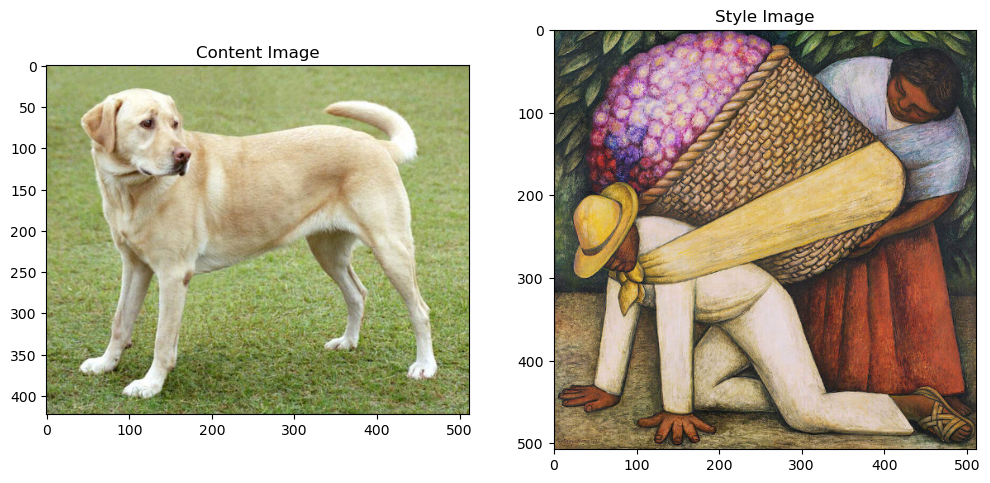

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

Now let see how it works

2023-02-09 11:21:18.468040: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


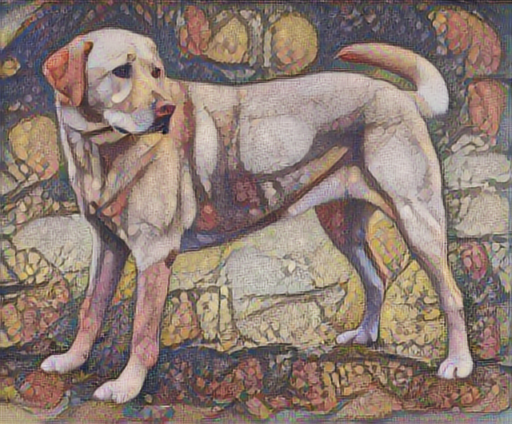

In [20]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

It says in the tutorial:
    
**Use the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.**

Let see if this is true, we now load a VGG19 and test run it on our image to ensure it's used correctly:

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [22]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 1us/step


[('Labrador_retriever', 0.49038258),
 ('golden_retriever', 0.23633678),
 ('kuvasz', 0.035026766),
 ('Chesapeake_Bay_retriever', 0.025488177),
 ('Greater_Swiss_Mountain_dog', 0.019346984)]

Now load a VGG19 without the classification head, and list the layer names

In [23]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [24]:
print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


The idea then is to modify this network to perform the style transfer. This is done in the tutorial, and we skip it in this discussion.